## IST 718
### Lab 2 (aka Lab6)
### Andrew Zelazny
### August 10, 2019
This notebook performs the data analysis required to complete Lab 2 for IST718 Big Data Analytics.

The task was to Zillow house price data from 1997 to the present, and identify 3 zip codes best suited to investment.

### Sources:
- Zillow Data:
- State Names to Abbreviations: https://pypi.org/project/us/
- Prophet: https://facebook.github.io/prophet/
- Prophet Crash Course: https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
- Pandas Timeseries: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
- Income Data: https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi
- Population Data: https://factfinder.census.gov/bkmk/table/1.0/en/PEP/2018/PEPANNRES/0100000US.16200

In [1]:
#!pip install us

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import us

In [2]:
# Load Zillow data
csv_file = r'Zip_Zhvi_SingleFamilyResidence.csv'
data = pd.read_csv(csv_file, encoding='ISO-8859-1', dtype={'RegionName': 'str'})
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,337200.0,338200.0,339000.0,...,1047600,1049400,1048800,1049900,1054300,1059400,1067800,1080400,1082300,1072200
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,212200.0,...,338100,336700,336100,336200,335500,334200,333500,333500,333400,332300
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,502900.0,504900.0,506300.0,...,1319100,1317900,1319800,1324200,1330000,1336400,1342000,1347400,1345200,1334500
3,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,95400.0,95600.0,95800.0,...,178500,179400,180300,181100,182100,183300,183000,181800,181800,182800
4,93144,79936,El Paso,TX,El Paso,El Paso County,5,77300.0,77300.0,77300.0,...,125700,126400,126900,127600,128200,128600,128900,128700,128500,128800


### Clean Data

In [173]:
print(data.shape)

# Rename column to ZipCode
data.rename(columns={'RegionName': 'ZipCode'}, inplace=True)
print(data.ZipCode.nunique())

# Drop Missing values
data.dropna(inplace=True)
data.head()

# Set the index to the ZipCode
data.set_index('ZipCode', drop=False, inplace=True) # Set the index of the data fram to RegionID

# Split the time_data into its own dataframe for simpler indexing with ZipCode
time_data = data.iloc[:, 7:] # Split out the time series data
time_data = time_data.loc[:, time_data.columns >= '1997'].transpose()
time_data.set_index(pd.DatetimeIndex(time_data.index), inplace=True)
time_data.head()

(13301, 286)
13301


ZipCode,60657,77494,60614,77449,79936,77084,10467,11226,60640,94109,...,92341,03765,84781,12429,97028,97102,01338,03293,40404,89155
1997-01-01,344900.0,197300.0,503200.0,96600.0,77800.0,95800.0,151500.0,168000.0,220100.0,825100.0,...,83500.0,74400.0,138700.0,77700.0,136000.0,193000.0,91800.0,90600.0,59500.0,176500.0
1997-02-01,346200.0,195400.0,501900.0,96400.0,77900.0,95500.0,151600.0,168900.0,221100.0,834600.0,...,83500.0,73800.0,139100.0,77900.0,136000.0,194400.0,91900.0,90200.0,59900.0,176700.0
1997-03-01,347000.0,193000.0,499500.0,96200.0,77900.0,95300.0,151700.0,169700.0,222000.0,843600.0,...,83400.0,73200.0,139500.0,78000.0,135700.0,195500.0,92200.0,89900.0,60300.0,176800.0
1997-04-01,347900.0,191800.0,497500.0,96100.0,77800.0,95100.0,151800.0,170400.0,223100.0,853500.0,...,83200.0,72700.0,140000.0,78000.0,135200.0,196500.0,92500.0,89700.0,60800.0,176800.0
1997-05-01,349100.0,191800.0,495900.0,96200.0,77800.0,95100.0,152000.0,171100.0,224300.0,864000.0,...,83000.0,72200.0,140500.0,78100.0,134500.0,197500.0,92900.0,89500.0,61300.0,176900.0


In [174]:
# Split the informational data
info_data = data.iloc[:, 0:7]
info_data.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank
ZipCode,,,,,,,
60657,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1
77494,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2
60614,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3
77449,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4
79936,93144,79936,El Paso,TX,El Paso,El Paso County,5


In [5]:
# Add column for City, State combination, used for matching with population data
info_data.loc[:, 'StateName'] = info_data.apply(lambda row: us.states.lookup(row['State']).name, axis=1)
info_data.loc[:, 'CityState'] = info_data.apply(lambda row: '{}, {}'.format(row['City'], row['StateName']), axis=1)
city_zip_dict = info_data.set_index(info_data.CityState).loc[:, 'ZipCode'].to_dict()
info_data.head()


,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,StateName,CityState
ZipCode,,,,,,,,,
60657,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,Illinois,"Chicago, Illinois"
77494,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,Texas,"Katy, Texas"
60614,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,Illinois,"Chicago, Illinois"
77449,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,Texas,"Katy, Texas"
79936,93144,79936,El Paso,TX,El Paso,El Paso County,5,Texas,"El Paso, Texas"


In [6]:
# Create dictionary of zip codes by Metro
metro_zips_dict = info_data.set_index('Metro').loc[:, 'ZipCode'].to_dict()
metro_zips_dict = {}
for metro, group in info_data.groupby('Metro'):
    zips = group.ZipCode.unique()
    metro_zips_dict.update({metro: zips})

# Aggregate mean price data by metro
metro_avg_dict = {}
for metro in metro_zips_dict.keys():
    zips = metro_zips_dict.get(metro)
    
    mean_price = time_data.loc[:, zips].mean(axis=1)
    
    metro_avg_dict.update({metro: mean_price})



In [9]:
# Check to make sure all ZipCode values are 5 characthers long
info_data.loc[:, 'Len'] = info_data.ZipCode.apply(lambda x: len(str(x)))
info_data.loc[info_data.Len != 5, :]

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,StateName,CityState,Len
ZipCode,,,,,,,,,,


In [8]:
# Identify Arkansas metros
ark = info_data.loc[info_data.State == 'AR', :]
ark.Metro.unique()

array(['Jonesboro', 'Hot Springs', 'Little Rock-North Little Rock-Conway',
       'Fayetteville-Springdale-Rogers', 'Paragould', 'Texarkana',
       'Searcy', 'Mountain Home', 'Fort Smith', 'Harrison', 'Batesville',
       'Memphis', 'Russellville'], dtype=object)

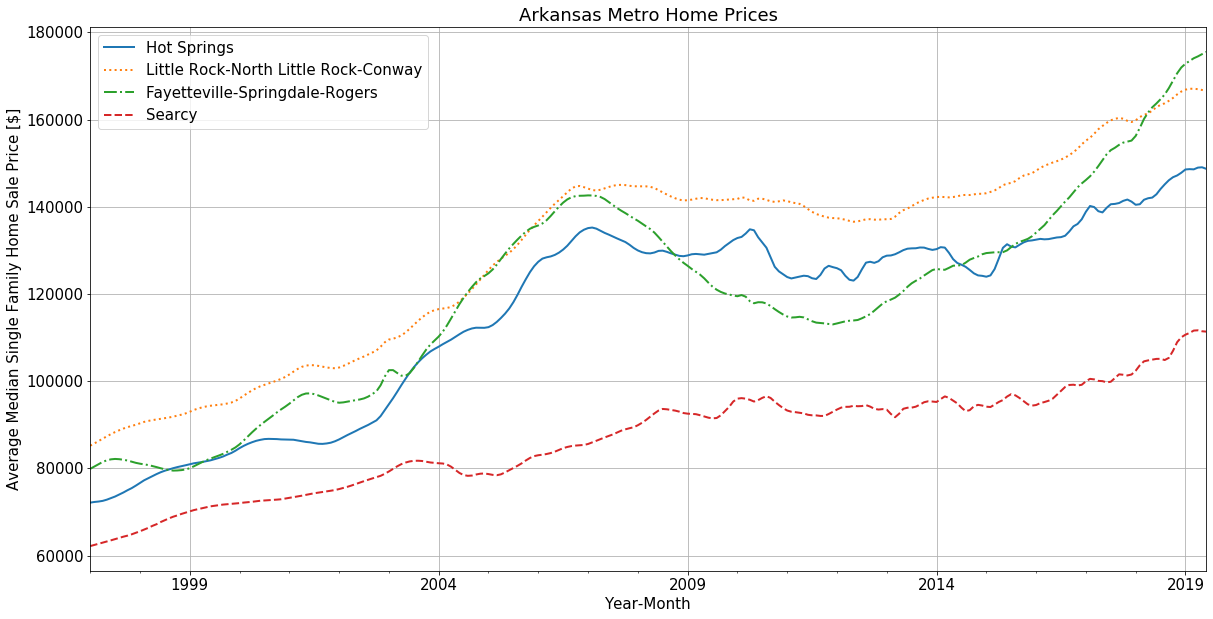

In [175]:
# Import plotting library
import matplotlib.pyplot as plt
import itertools

# Set default plotting settings
pd.plotting.register_matplotlib_converters()
rc_params = {
    'font.size': 15,
    'lines.linewidth': 2
}
plt.rcParams.update(rc_params)


# For each of the selected Arkansas metros, plot the metro-average Median home price
ark_metros = ['Hot Springs', 'Little Rock-North Little Rock-Conway', 'Fayetteville-Springdale-Rogers', 'Searcy']

ark_metro_avg = {}
for metro in ark_metros:
    # Get avereage price data from aggregation dictionary
    metro_mean = metro_avg_dict.get(metro)
    ark_metro_avg.update({metro: metro_mean})

# Convert to dataframe and plot with labels
ark_metro_df = pd.DataFrame.from_dict(ark_metro_avg)
fig, ax = plt.subplots(figsize=(20, 10))
my_lines = ['-', ':', '-.', '--'] * 100
ark_metro_df.plot(ax=ax, style=my_lines)
ax.set_xlabel('Year-Month')
ax.set_ylabel('Average Median Single Family Home Sale Price [$]')
ax.set_title(f'Arkansas Metro Home Prices')
ax.grid(True)
plt.show()


### Get Income Data

In [11]:
years = list(np.arange(2013, 2017))
income_dict = {}


for year in years:
    csv_file = 'AGI_{}.csv'.format(year)
    columns = ['STATE', 'ZIPCODE', 'N1', 'AGI', 'TotalIncome']
    income_data = pd.read_csv(csv_file, encoding='ISO-8859-1', header=0, dtype={'ZIPCODE': 'str', 'zipcode': 'str'})
    income_data.rename(columns=str.upper, inplace=True)
    income_data.rename(columns={'A00100': 'AGI', 'A02650': 'TotalIncome'}, inplace=True)
    income_data = income_data[columns]
    income_data.set_index(income_data.ZIPCODE, drop=False, inplace=True)
    
    temp = income_data.loc[:, 'TotalIncome'].to_dict()
    
    income_dict.update({year: temp})

income_df = pd.DataFrame(income_dict).dropna()
income_df = income_df.transpose()
income_df.set_index(pd.to_datetime(income_df.index, format='%Y'), inplace=True)
income_df.to_csv('Income_Data.csv')


income_df.head()

,35004,35005,35006,35007,35010,35014,35016,35019,35020,35022,...,83114,83115,83118,83120,83122,83123,83126,83127,83128,83414
2013-01-01,15359.0,0.0,0.0,58105.0,82076.0,0.0,31860.0,0.0,0.0,43466.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18104.0,21873.0,12362.0
2014-01-01,16122.0,0.0,0.0,72931.0,65935.0,0.0,32157.0,0.0,0.0,52343.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29145.0,24701.0,16641.0
2015-01-01,18072.0,0.0,0.0,74116.0,78689.0,8642.0,47716.0,0.0,0.0,53947.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28093.0,35633.0,24795.0
2016-01-01,20250.0,0.0,0.0,79516.0,77747.0,8697.0,48522.0,0.0,5630.0,56439.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24058.0,43257.0,32793.0


### Check if the Zip Codes in the Zillow data are available in the Income Data

In [12]:
info_data.loc[:, 'HasIncome'] = info_data.ZipCode.apply(lambda x: x in income_df.columns)
print(info_data.HasIncome.count())
info_data.head()

13301


,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,StateName,CityState,HasIncome
ZipCode,,,,,,,,,,
60657,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,Illinois,"Chicago, Illinois",True
77494,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,Texas,"Katy, Texas",True
60614,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,Illinois,"Chicago, Illinois",True
77449,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,Texas,"Katy, Texas",True
79936,93144,79936,El Paso,TX,El Paso,El Paso County,5,Texas,"El Paso, Texas",True


### Get Population data

In [13]:
pop_csv = pd.read_csv('POP_EST_2010_to_2018.csv', encoding='ISO-8859-1', header=0, skiprows=[1])
pop_csv.head()

,GEO.id,GEO.id2,GEO.display-label,rescen42010,resbase42010,respop72010,respop72011,respop72012,respop72013,respop72014,respop72015,respop72016,respop72017,respop72018
0,1620000US0100124,100124,"Abbeville city, Alabama",2688,2688,2684,2677,2629,2612,2595,2588,2573,2566,2563
1,1620000US0100460,100460,"Adamsville city, Alabama",4522,4516,4510,4496,4474,4453,4432,4406,4373,4342,4325
2,1620000US0100484,100484,"Addison town, Alabama",758,754,751,751,744,743,740,735,734,728,724
3,1620000US0100676,100676,"Akron town, Alabama",356,356,355,345,345,341,339,337,332,332,330
4,1620000US0100820,100820,"Alabaster city, Alabama",30352,31091,31186,31346,31653,31946,32149,32739,32984,33223,33340


### Extract the estimated population columns for 2010 - 2018

In [176]:
pop_data = pop_csv.iloc[:, 2:]
pop_data.drop(labels=['rescen42010', 'resbase42010'], axis=1, inplace=True) # remove census data from 2010
pop_data.rename(columns=lambda x: x.replace('respop7', ''), inplace=True) 
pop_data.rename(columns={'GEO.display-label': 'City'}, inplace=True) # Change column name fo CIty
pop_data.loc[:, 'State'] = pop_data.apply(lambda row: row['City'].split(',')[1].strip(' '), axis=1) # Split out State from City, State
pop_data.City = pop_data.City.apply(lambda x: x.replace(' city', '')) # Remove extra "city" from City
pop_data.City = pop_data.City.apply(lambda x: x.replace(' town', '')) # Remove extra "town" from City
print(pop_data.shape)
pop_data.head()

(19495, 11)


,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,State
0,"Abbeville, Alabama",2684,2677,2629,2612,2595,2588,2573,2566,2563,Alabama
1,"Adamsville, Alabama",4510,4496,4474,4453,4432,4406,4373,4342,4325,Alabama
2,"Addison, Alabama",751,751,744,743,740,735,734,728,724,Alabama
3,"Akron, Alabama",355,345,345,341,339,337,332,332,330,Alabama
4,"Alabaster, Alabama",31186,31346,31653,31946,32149,32739,32984,33223,33340,Alabama


In [177]:
pop_data.loc[:, 'ZipCode'] = pop_data.apply(lambda row: city_zip_dict.get(row['City'], np.nan), axis=1) # Add zip code to pop_data
pop_data.head()

,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,State,ZipCode
0,"Abbeville, Alabama",2684,2677,2629,2612,2595,2588,2573,2566,2563,Alabama,NaN
1,"Adamsville, Alabama",4510,4496,4474,4453,4432,4406,4373,4342,4325,Alabama,35005
2,"Addison, Alabama",751,751,744,743,740,735,734,728,724,Alabama,NaN
3,"Akron, Alabama",355,345,345,341,339,337,332,332,330,Alabama,NaN
4,"Alabaster, Alabama",31186,31346,31653,31946,32149,32739,32984,33223,33340,Alabama,35114


In [178]:
pop_df = pop_data.set_index('ZipCode', drop=False).drop(columns=['City', 'State', 'ZipCode']) # Drop missing zip codes that don't match with those in time_data
pop_df = pop_df.loc[np.logical_not(pd.isnull(pop_df.index)), :].transpose() # transpose to enable indexing same as time_data
pop_df.head()

ZipCode,35005,35114,35010,35120,36311,35953,35614,35954,36832,36507,...,82930,82636,82716,82935,82520,82072,82937,82082,82501,82901
2010,4510,31186,14930,4081,763,2217,22003,6044,53802,8272,...,12367,2618,31526,12398,7617,30953,2107,1165,10939,23016
2011,4496,31346,14890,4097,754,2217,22752,6020,54968,8361,...,12203,2763,31936,12432,7676,31257,2091,1163,11023,23340
2012,4474,31653,14764,4124,757,2226,23345,5995,57183,8520,...,12240,2824,32957,12698,7769,31725,2100,1180,11174,23923
2013,4453,31946,14836,4173,747,2249,23787,5954,58863,8783,...,12204,2884,33199,12657,7798,31889,2098,1185,11180,24089
2014,4432,32149,14787,4175,741,2245,24323,5909,60421,8909,...,12116,2860,33342,12577,7730,31881,2086,1173,11095,23976


### Check to see how many Zip Codes in the Zillow data are in the population data

In [17]:
info_data.loc[:, 'HasPopulation'] = info_data.apply(lambda row: row['ZipCode'] in pop_df.columns, axis=1)
info_data.ZipCode[info_data.HasPopulation].count()

4682

#### Not enough zip codes with useful population data...

### Introducting the Prophet, for Time-Series Forecasting
###### and world domination...


In [19]:
from fbprophet import Prophet

In [180]:
# UDF to calculate mean absloute perecent error
def calc_mape(df_prophet):
    y_true = df_prophet.loc[:, 'y'].values
    y_pred = df_prophet.loc[:, 'yhat'].values
    mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100
    return mape

# UDF to calculate ROI
def calc_roi_range(df_prophet):
    ref = df_prophet.loc[:, 'y'].values[0]
    avg_roi = df_prophet.loc[:, 'yhat'].values[-1] / ref
    low_roi = df_prophet.loc[:, 'yhat_lower'].values[-1] / ref
    high_roi = df_prophet.loc[:, 'yhat_upper'].values[-1] / ref

    return (avg_roi, low_roi, high_roi)

### Build a forecasting model for each of the metro areas in the Zillow data

In [31]:
import time

t0 = time.time()

metro_model_dict = {}
for idx, metro in enumerate(metro_avg_dict.keys()):
    
    try:
        # Extract training data for the zipcode
        train = pd.DataFrame(metro_avg_dict.get(metro))
        train.rename(columns={0: 'y'}, inplace=True)
        train.loc[:, 'ds'] = pd.to_datetime(train.index, format='%Y-%m')
        train = train.loc[train.ds < '2018-01-01', :]
        train = train.loc[:, ['ds', 'y']]

        # Find the last date in the training data
        last_date = train.ds[-1]

        # create the model
        m = Prophet(
            growth='linear',
            weekly_seasonality=False,
            daily_seasonality=False,
            n_changepoints=15,
            changepoint_prior_scale=10,
            mcmc_samples=0
        )
        m.fit(train)

        # Create future data frame
        future = m.make_future_dataframe(periods=12, freq='m', include_history=True)

        # Adjust dates in future to be on the first of the month
        new_range = future.ds > last_date
        future.loc[new_range, :] = future.loc[new_range, :] + pd.Timedelta('1 day')

        # Forecast pricies into the future
        forecast = m.predict(future)
        forecast.set_index(future.ds, drop=False, inplace=True)
        #forecast.index.rename('Date', inplace=True)

        # Merge the true data into the forecast dataframe
        forecast.loc[:, 'y'] = train.loc[forecast.ds, 'y'].values

        # Get metrics for the model
        mape = calc_mape(forecast.loc[train.index, :])
               #calc_mape(forecast.loc[train.index, :])
        roi = calc_roi_range(forecast)

        if idx % 5 == 0:
            print('Progress: {}/{}, Metro: {}'.format(idx+1, len(metro_avg_dict), metro))
            print("Time elapsed: {:.2f} s".format(time.time() - t0))

        metro_model_dict.update({metro: {'m': m, 'forecast': forecast, 'mape': mape, 'roi': roi[0], 'low': roi[1], 'high': roi[2]}})
    except Exception as e:
        print('Progress: {}/{}, Metro: {}'.format(idx+1, len(metro_avg_dict), metro))
        print(e)
        
    #if idx >= 5:
    #    break

print("Time elapsed: {:.2f} s".format(time.time() - t0))    

Progress: 1/719, Metro: Aberdeen
Time elapsed: 2.71 s
Progress: 6/719, Metro: Alamogordo
Time elapsed: 15.80 s
Progress: 11/719, Metro: Alexander City
Time elapsed: 28.99 s
Progress: 16/719, Metro: Alpena
Time elapsed: 42.40 s
Progress: 21/719, Metro: Ames
Time elapsed: 55.63 s
Progress: 26/719, Metro: Appleton
Time elapsed: 68.71 s
Progress: 31/719, Metro: Ashland
Time elapsed: 82.19 s
Progress: 36/719, Metro: Atlanta-Sandy Springs-Roswell
Time elapsed: 95.48 s
Progress: 41/719, Metro: Augusta-Waterville
Time elapsed: 109.87 s
Progress: 46/719, Metro: Baltimore-Columbia-Towson
Time elapsed: 123.75 s
Progress: 51/719, Metro: Barre
Time elapsed: 136.90 s
Progress: 56/719, Metro: Baton Rouge
Time elapsed: 149.87 s
Progress: 61/719, Metro: Beaver Dam
Time elapsed: 163.21 s
Progress: 66/719, Metro: Bellingham
Time elapsed: 176.51 s
Progress: 71/719, Metro: Big Rapids
Time elapsed: 189.84 s
Progress: 76/719, Metro: Blacksburg-Christiansburg-Radford
Time elapsed: 202.85 s
Progress: 81/719, M

In [189]:
# Convert metro model results into dataframe
metro_results_df = pd.DataFrame(metro_model_dict).transpose()
metro_results_df.to_csv('Zelazny-Metro_Results.csv') # Save metro results to a .csv so it can be reloaded without waiting for models to be built again

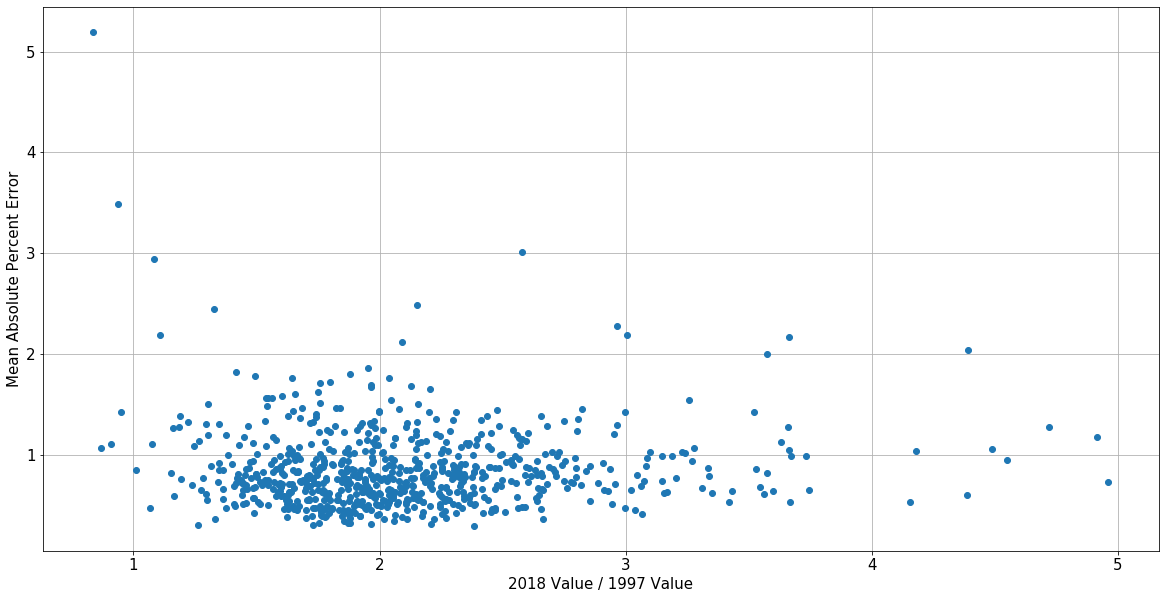

In [48]:
# PLot metro model results
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(metro_results_df.roi, metro_results_df.mape, axes=ax, marker='o', linestyle='')
ax.grid(True)
ax.set_xlabel('2018 Value / 1997 Value')
ax.set_ylabel('Mean Absolute Percent Error')
plt.show()

In [63]:
# Identify top metro areas for further analysis
top_metros = metro_results_df.loc[metro_results_df.roi > 4, :]
top_metros.loc[:, 'Metro'] = top_metros.index
top_metros.loc[:, 'Present Avg Median Price'] = top_metros.apply(lambda x: metro_avg_dict.get(x['Metro']).values[-1], axis=1)
top_metros.loc[:, 'Present Avg Median Price'] = top_metros.loc[:, 'Present Avg Median Price'].map('${:,.2f}'.format)
top_metros.loc[:, ['mape', 'roi', 'low', 'high', 'Present Avg Median Price']]


,mape,roi,low,high,Present Avg Median Price
Corvallis,1.18135,4.91469,4.76774,5.03259,"$350,166.67"
Huntingdon,1.05684,4.48814,4.36494,4.6442,"$120,850.00"
Los Angeles-Long Beach-Anaheim,0.536661,4.15598,4.02278,4.268,"$943,470.43"
San Francisco-Oakland-Hayward,0.949296,4.55144,4.45091,4.67957,"$1,342,274.02"
San Jose-Sunnyvale-Santa Clara,1.27678,4.71931,4.59881,4.82194,"$1,500,580.00"
Selinsgrove,2.04086,4.39077,4.12105,4.70883,"$158,866.67"
Sioux Falls,0.728621,4.95986,4.89465,5.0539,"$223,900.00"
State College,1.03761,4.18036,4.09773,4.26764,"$252,800.00"
Vineyard Haven,0.601105,4.3887,4.30108,4.46276,"$921,360.00"


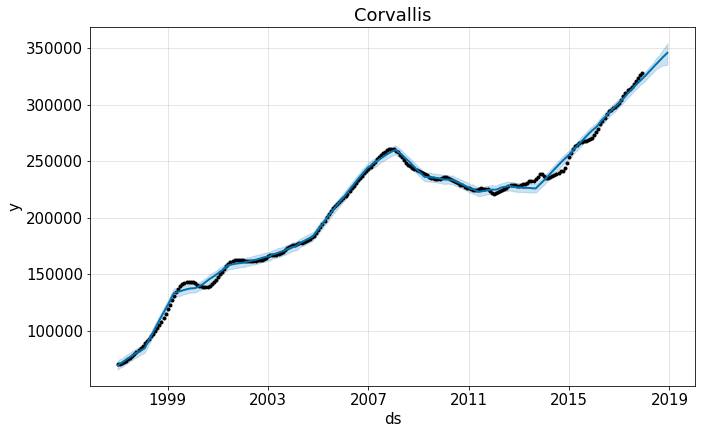

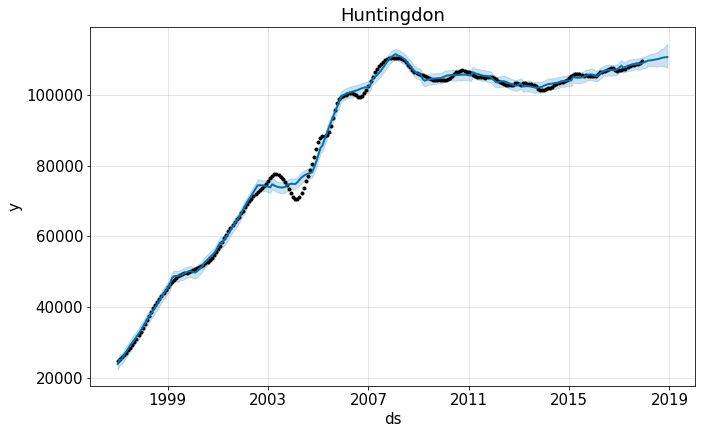

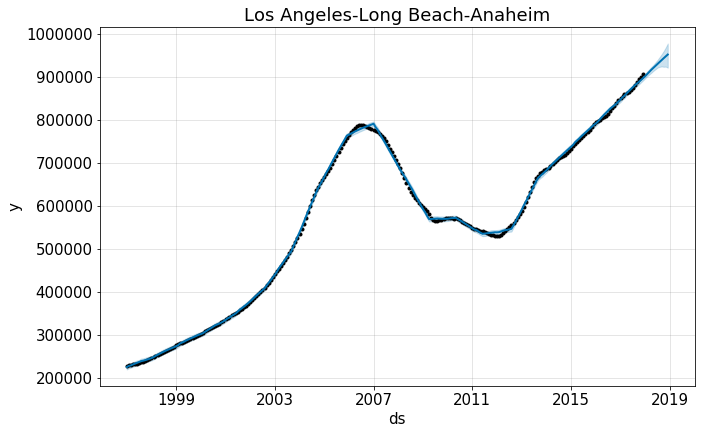

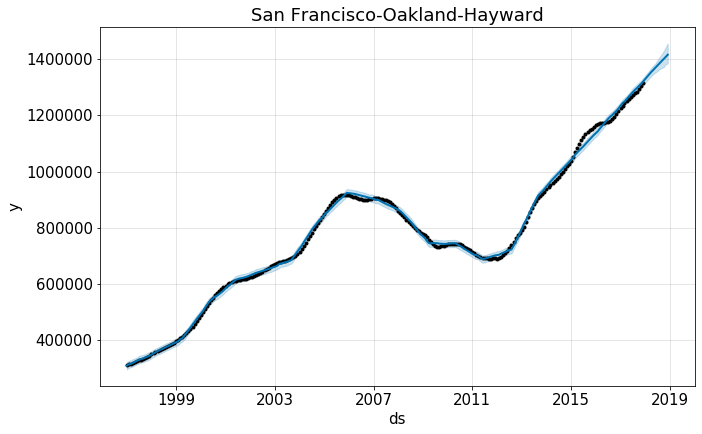

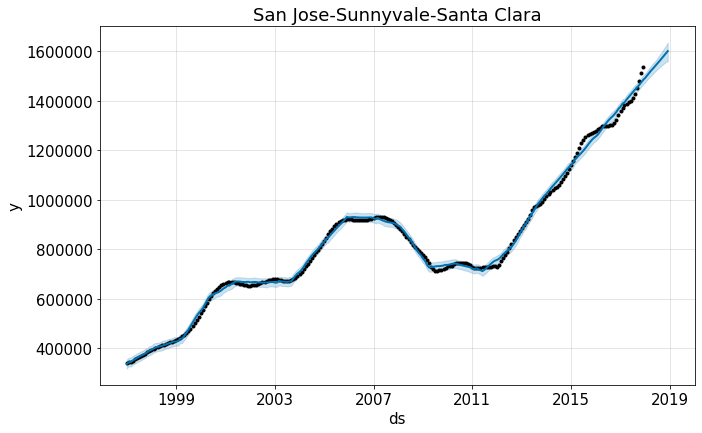

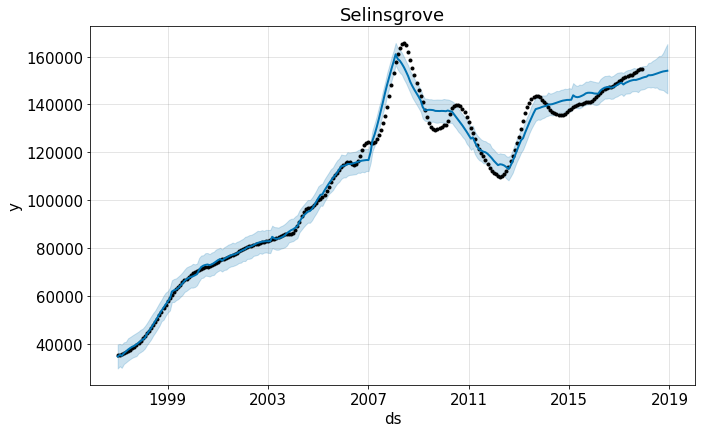

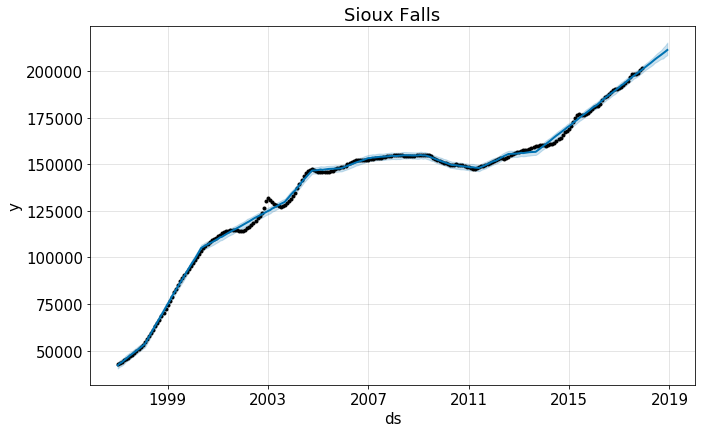

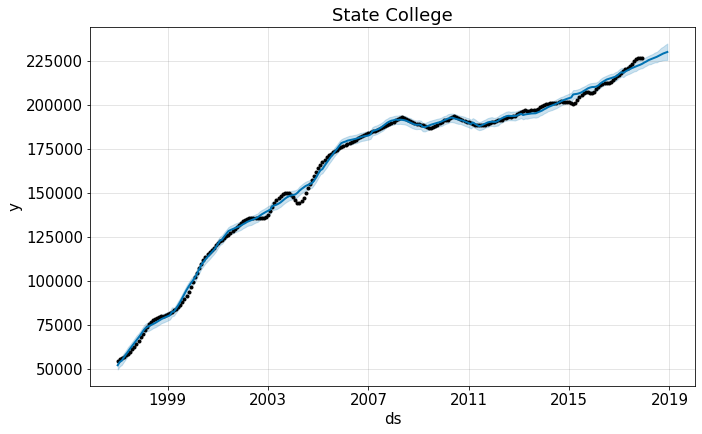

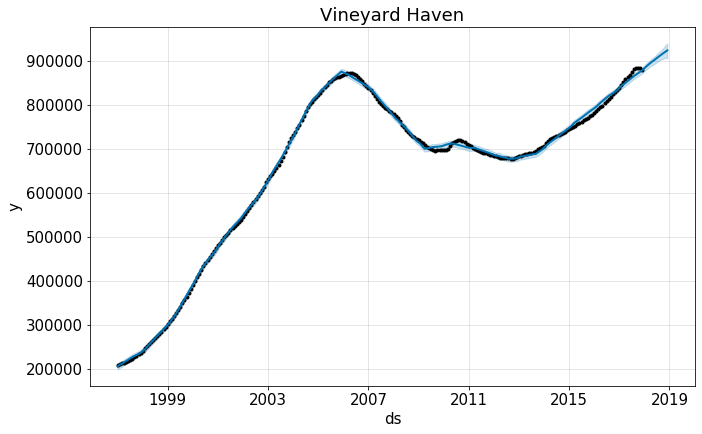

In [91]:
# PLot fits for top_metros

for metro in top_metros.index:
    m = top_metros.loc[metro, 'm']
    forecast = top_metros.loc[metro, 'forecast']
    pd.plotting.register_matplotlib_converters()
    fig1 = m.plot(forecast)
    
    axes = fig1.get_axes()
    axes[0].set_title(metro)


In [109]:
# Create dictionary of zip codes in top metro areas
top_zips_dict = {}
for metro in top_metros.index:
    zips = metro_zips_dict.get(metro)
    top_zips_dict.update({metro: zips})

### Build prediction models for each zip code in the top metros

In [112]:
t0 = time.time()

models_dict_zips = {}
for metro in top_zips_dict.keys():
    zips = top_zips_dict.get(metro)

    for idx, zipcode in enumerate(zips):

        try:
            # Extract training data for the zipcode
            train = pd.DataFrame(time_data.loc[:, zipcode])
            train.rename(columns={zipcode: 'y'}, inplace=True)
            train.loc[:, 'ds'] = pd.to_datetime(train.index, format='%Y-%m')
            train = train.loc[train.ds < '2018-01-01', :]
            train = train.loc[:, ['ds', 'y']]

            # Find the last date in the training data
            last_date = train.ds[-1]

            # create the model
            m = Prophet(
                growth='linear',
                weekly_seasonality=False,
                daily_seasonality=False,
                n_changepoints=15,
                changepoint_prior_scale=10,
                mcmc_samples=0
            )
            m.fit(train)

            # Create future data frame
            future = m.make_future_dataframe(periods=12, freq='m', include_history=True)

            # Adjust dates in future to be on the first of the month
            new_range = future.ds > last_date
            future.loc[new_range, :] = future.loc[new_range, :] + pd.Timedelta('1 day')

            # Forecast pricies into the future
            forecast = m.predict(future)
            forecast.set_index(future.ds, drop=False, inplace=True)
            #forecast.index.rename('Date', inplace=True)

            # Merge the true data into the forecast dataframe
            forecast.loc[:, 'y'] = train.loc[forecast.ds, 'y'].values

            # Get metrics for the model
            mape = calc_mape(forecast.loc[train.index, :])
                   #calc_mape(forecast.loc[train.index, :])
            roi = calc_roi_range(forecast)

            if idx % 5 == 0:
                print('Progress: {}/{}, Zip: {}'.format(idx, info_data.shape[0], zipcode))
                print("Time elapsed: {:.2f} s".format(time.time() - t0))

            models_dict_zips.update({zipcode: {'m': m, 'forecast': forecast, 'mape': mape, 'roi': roi[0], 'low': roi[1], 'high': roi[2]}})
        except Exception as e:
            print('Progress: {}/{}, Zip: {}'.format(idx+1, info_data.shape[0], zipcode))
            print(e)

        #if idx >= 5:
        #    break

    print("Time elapsed: {:.2f} s".format(time.time() - t0))
        


Progress: 0/13301, Zip: 97330
Time elapsed: 2.71 s
Time elapsed: 8.29 s
Progress: 0/13301, Zip: 16652
Time elapsed: 10.99 s
Time elapsed: 19.28 s
Progress: 0/13301, Zip: 90250
Time elapsed: 22.22 s
Progress: 5/13301, Zip: 90650
Time elapsed: 36.31 s
Progress: 10/13301, Zip: 92804
Time elapsed: 50.02 s
Progress: 15/13301, Zip: 90706
Time elapsed: 64.02 s
Progress: 20/13301, Zip: 90027
Time elapsed: 78.36 s
Progress: 25/13301, Zip: 92630
Time elapsed: 92.81 s
Progress: 30/13301, Zip: 92646
Time elapsed: 106.39 s
Progress: 35/13301, Zip: 90640
Time elapsed: 120.43 s
Progress: 40/13301, Zip: 92704
Time elapsed: 134.29 s
Progress: 45/13301, Zip: 90255
Time elapsed: 148.97 s
Progress: 50/13301, Zip: 90049
Time elapsed: 163.11 s
Progress: 55/13301, Zip: 91766
Time elapsed: 176.87 s
Progress: 60/13301, Zip: 90813
Time elapsed: 191.10 s
Progress: 65/13301, Zip: 91702
Time elapsed: 204.73 s
Progress: 70/13301, Zip: 90630
Time elapsed: 218.48 s
Progress: 75/13301, Zip: 93551
Time elapsed: 231.98 

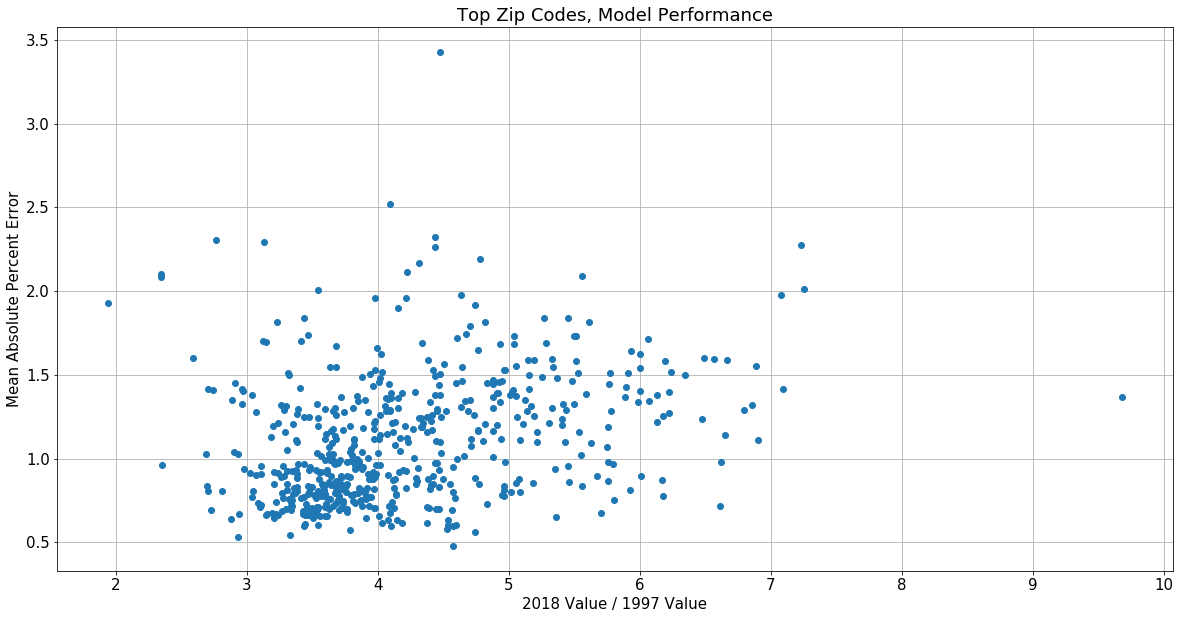

In [126]:
# 
top_zips_df = pd.DataFrame(models_dict_zips).transpose()

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(top_zips_df.roi, top_zips_df.mape, axes=ax, marker='o', linestyle='')
ax.grid(True)
ax.set_xlabel('2018 Value / 1997 Value')
ax.set_ylabel('Mean Absolute Percent Error')
ax.set_title('Top Zip Codes, Model Performance')
plt.show()

In [152]:
top_zips_df.loc[:, 'ZipCode'] = top_zips_df.index
top_zips_df.loc[:, 'CityState'] = info_data.loc[top_zips_df.index, 'CityState']
top_zips_df.loc[:, 'Metro'] = info_data.loc[top_zips_df.index, 'Metro']
top_zips_df.loc[:, 'Present Avg Median Price'] = top_zips_df.apply(lambda x: time_data.loc[:, x['ZipCode']].values[-1], axis=1)
top_zips_df.loc[:, 'Present Avg Median Price'] = top_zips_df.loc[:, 'Present Avg Median Price'].map('${:,.2f}'.format)

sel = (top_zips_df.loc[:, 'roi'] >= 6.5) & (top_zips_df.loc[:, 'mape'] <= 1.5)
finalists = top_zips_df.loc[sel, :]
finalists.loc[:, 'CityState'] = info_data.loc[finalists.index, 'CityState']
finalists.loc[:, 'Metro'] = info_data.loc[finalists.index, 'Metro']
finalists

,m,forecast,mape,roi,low,high,ZipCode,Present Avg Median Price,CityState,Metro
90026,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_...,1.10998,6.90274,6.69389,7.08274,90026,"$980,000.00","Los Angeles, California",Los Angeles-Long Beach-Anaheim
90066,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,0.9784,6.61597,6.50642,6.74647,90066,"$1,502,300.00","Los Angeles, California",Los Angeles-Long Beach-Anaheim
90019,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,0.71979,6.61218,6.45655,6.77291,90019,"$1,149,100.00","Los Angeles, California",Los Angeles-Long Beach-Anaheim
90004,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,1.32009,6.85706,6.71163,7.03182,90004,"$1,630,700.00","Los Angeles, California",Los Angeles-Long Beach-Anaheim
90036,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,1.14367,6.65077,6.49348,6.81999,90036,"$1,855,200.00","Los Angeles, California",Los Angeles-Long Beach-Anaheim
90291,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,1.36747,9.68036,9.44992,9.95638,90291,"$2,087,400.00","Los Angeles, California",Los Angeles-Long Beach-Anaheim
90405,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,1.28829,6.79422,6.65221,6.92647,90405,"$1,970,600.00","Santa Monica, California",Los Angeles-Long Beach-Anaheim
90048,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,1.41811,7.0938,6.93593,7.2514,90048,"$2,185,500.00","Los Angeles, California",Los Angeles-Long Beach-Anaheim


In [146]:
# create filters based on current price range
numeric_values = top_zips_df.loc[:, 'Present Avg Median Price'].replace('[\$,]', '', regex=True).astype(float) # Convert currency values back to numeric data
mid_sel = (numeric_values <= 500000) & (numeric_values > 200000) # Select mid-range prices
low_sel = numeric_values < 200000 # select low-range prices

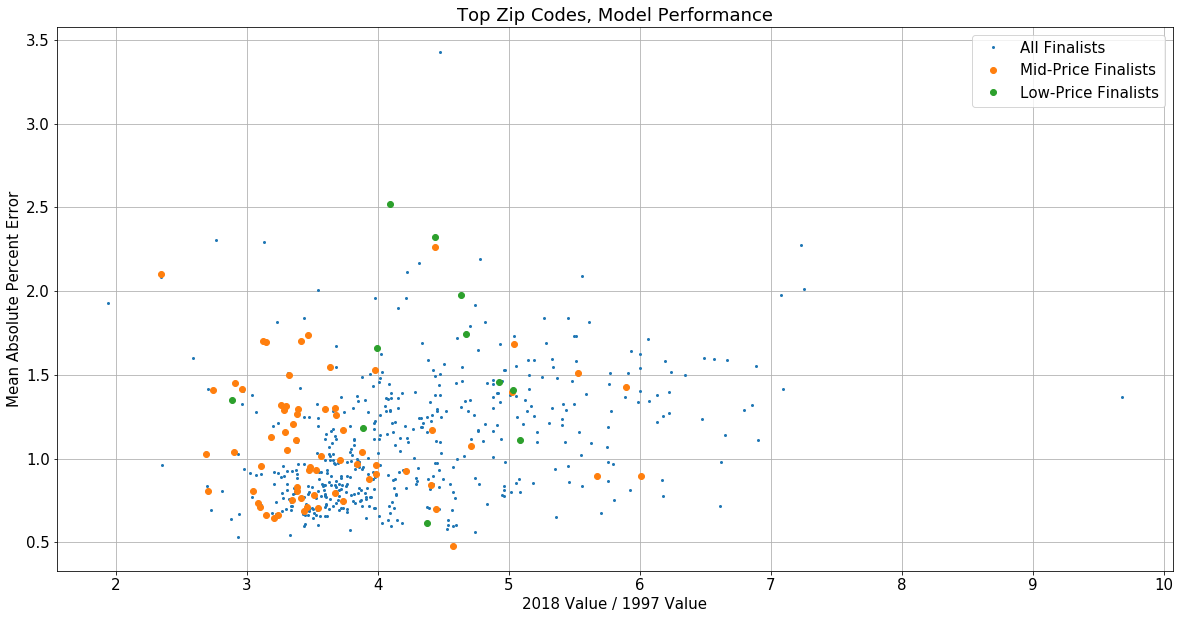

In [153]:
mid_price = top_zips_df.loc[mid_sel, :]
low_price = top_zips_df.loc[low_sel, :]

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(top_zips_df.roi, top_zips_df.mape, axes=ax, marker='o', linestyle='', label='All Finalists', markersize=2)
plt.plot(mid_price.roi, mid_price.mape, axes=ax, marker='o', linestyle='', label='Mid-Price Finalists')
plt.plot(low_price.roi, low_price.mape, axes=ax, marker='o', linestyle='', label='Low-Price Finalists')
ax.grid(True)
ax.set_xlabel('2018 Value / 1997 Value')
ax.set_ylabel('Mean Absolute Percent Error')
ax.set_title('Top Zip Codes, Model Performance')
plt.legend()
plt.show()

Text(0.5, 1, '16611, Porter, Pennsylvania')

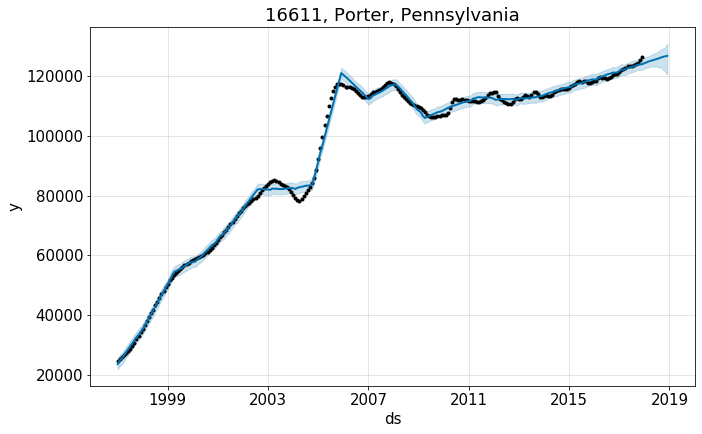

In [162]:
top_low = low_price.sort_values('roi').iloc[-1, :]
fig1 = top_low.m.plot(top_low.forecast)
axes = fig1.get_axes()
title = '{}, {}'.format(top_low.ZipCode, top_low.CityState)
axes[0].set_title(title)

Text(0.5, 1, '57110, Sioux Falls, South Dakota')

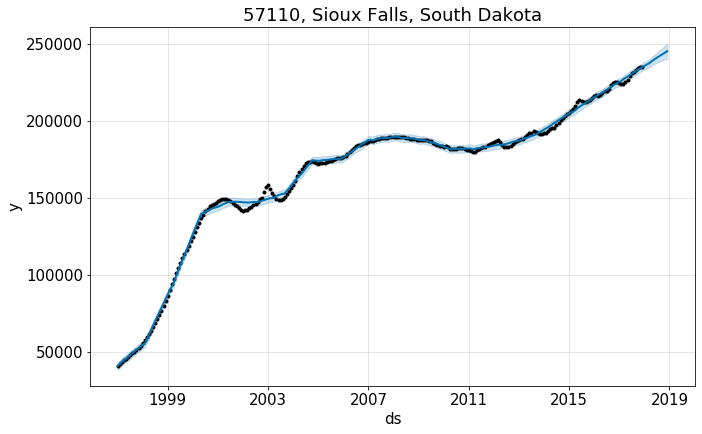

In [161]:
top_mid = mid_price.sort_values('roi').iloc[-1, :]
fig1 = top_mid.m.plot(top_mid.forecast)
axes = fig1.get_axes()
title = '{}, {}'.format(top_mid.ZipCode, top_mid.CityState)
axes[0].set_title(title)

In [187]:
# Select top 3 zip codes
finalists = finalists.sort_values('roi', ascending=False)
top_finalists = finalists.iloc[0:3, :]
top_finalists.to_csv('Zelazny-Final_ZipCodes.csv') # save final zip codes to .csv
top_finalists.loc[:, ['mape', 'roi', 'low', 'high', 'CityState', 'Present Avg Median Price']]

,mape,roi,low,high,CityState,Present Avg Median Price
90291,1.36747,9.68036,9.44992,9.95638,"Los Angeles, California","$2,087,400.00"
90048,1.41811,7.0938,6.93593,7.2514,"Los Angeles, California","$2,185,500.00"
90026,1.10998,6.90274,6.69389,7.08274,"Los Angeles, California","$980,000.00"


In [190]:
# Save final version of data frames for reference
time_data.to_csv('Zelazny-time_data.csv')
info_data.to_csv('Zelazny-info_data.csv')
top_zips_df.to_csv('Zelazny-top_zips_df.csv')

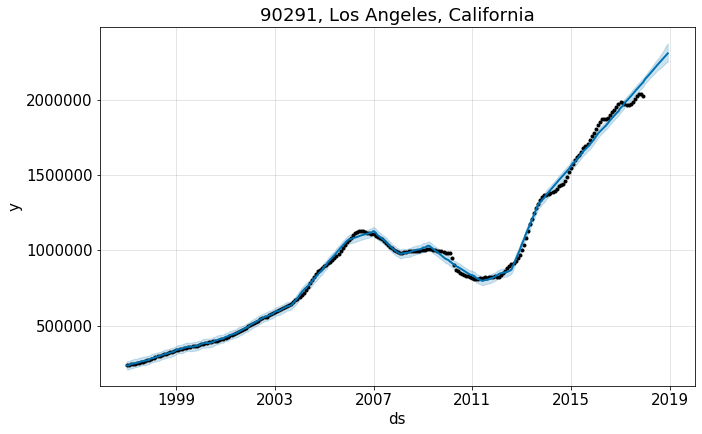

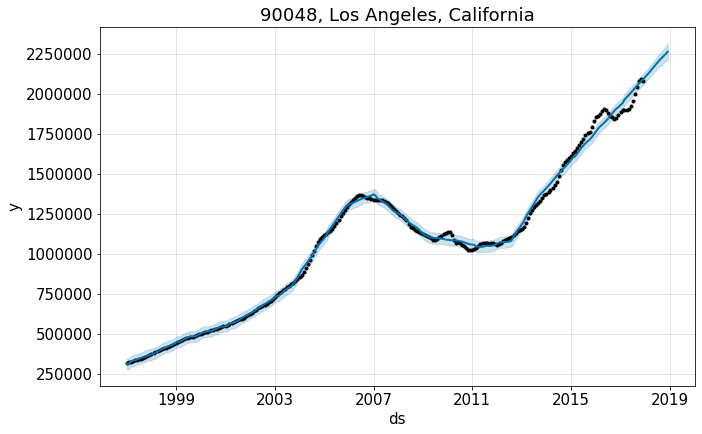

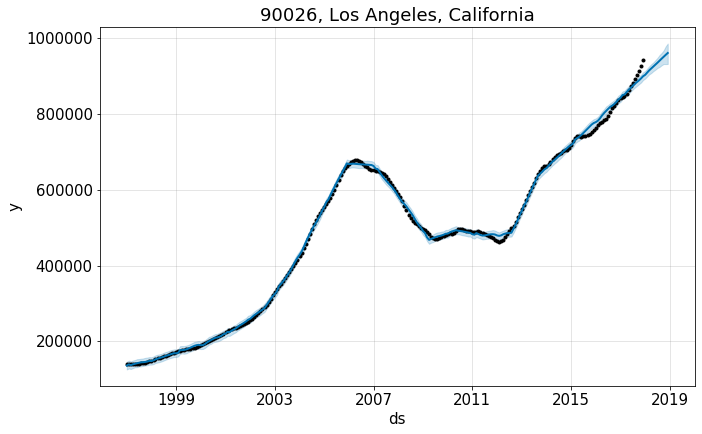

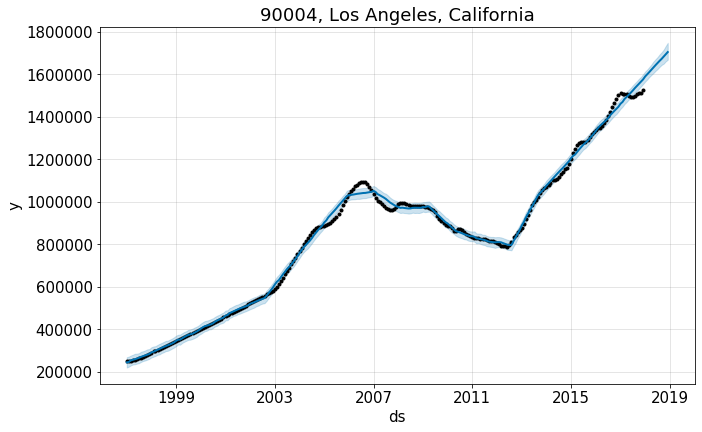

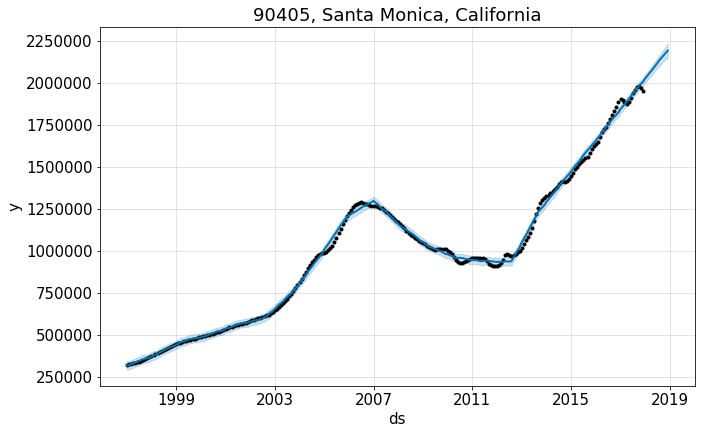

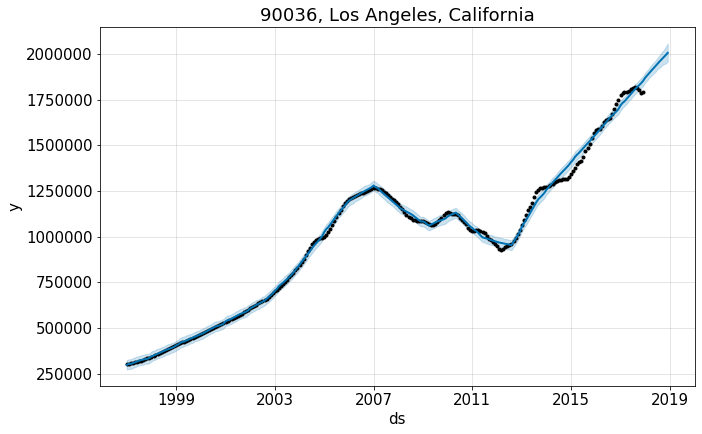

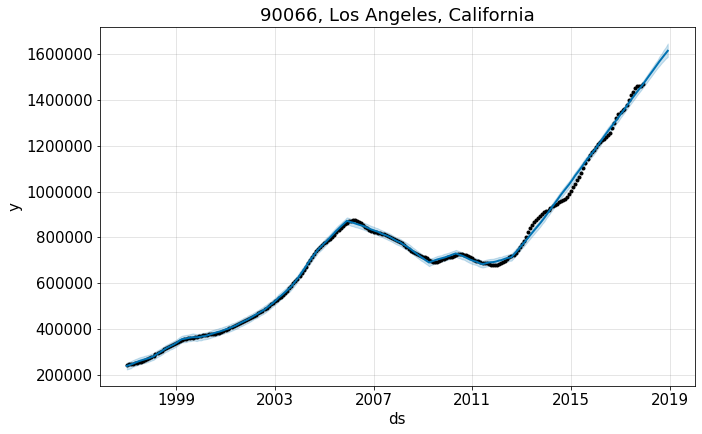

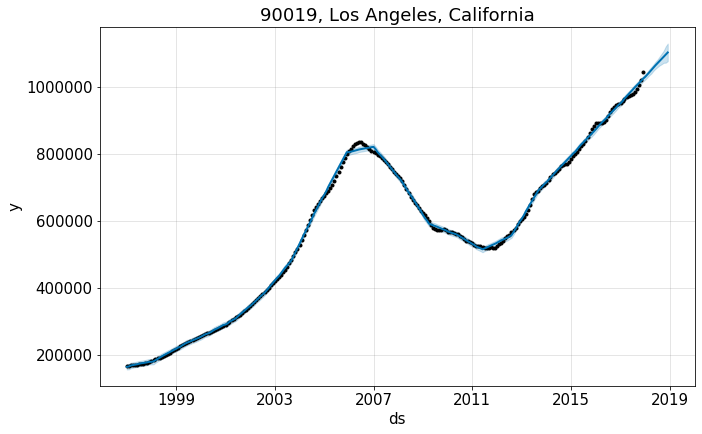

In [183]:
# Plot the predictions and actual data for the top 3 zip codes

for zipcode in finalists.index:
    m = finalists.loc[zipcode, 'm']
    forecast = finalists.loc[zipcode, 'forecast']
    pd.plotting.register_matplotlib_converters()
    fig1 = m.plot(forecast)
    
    axes = fig1.get_axes()
    label = '{}, {}'.format(zipcode, finalists.loc[zipcode, 'CityState'])
    axes[0].set_title(label)


### Scrap code...
##### to be run overnight, should've started sooner...


### Build models with Prophet using only Zillow data from 1997 - 2017

In [46]:
import time

t0 = time.time()


models_dict_basic = {}
for idx, zipcode in enumerate(info_data.ZipCode):
    
    try:
        # Extract training data for the zipcode
        train = pd.DataFrame(time_data.loc[:, zipcode])
        train.rename(columns={zipcode: 'y'}, inplace=True)
        train.loc[:, 'ds'] = pd.to_datetime(train.index, format='%Y-%m')
        train = train.loc[train.ds < '2018-01-01', :]
        train = train.loc[:, ['ds', 'y']]

        # Find the last date in the training data
        last_date = train.ds[-1]

        # create the model
        m = Prophet(
            growth='linear',
            weekly_seasonality=False,
            daily_seasonality=False,
            n_changepoints=15,
            changepoint_prior_scale=10,
            mcmc_samples=0
        )
        m.fit(train)

        # Create future data frame
        future = m.make_future_dataframe(periods=12, freq='m', include_history=True)

        # Adjust dates in future to be on the first of the month
        new_range = future.ds > last_date
        future.loc[new_range, :] = future.loc[new_range, :] + pd.Timedelta('1 day')

        # Forecast pricies into the future
        forecast = m.predict(future)
        forecast.set_index(future.ds, drop=False, inplace=True)
        #forecast.index.rename('Date', inplace=True)

        # Merge the true data into the forecast dataframe
        forecast.loc[:, 'y'] = train.loc[forecast.ds, 'y'].values

        # Get metrics for the model
        mape = calc_mape(forecast.loc[train.index, :])
               #calc_mape(forecast.loc[train.index, :])
        roi = calc_roi_range(forecast)

        if idx % 5 == 0:
            print('Progress: {}/{}, Zip: {}'.format(idx, info_data.shape[0], zipcode))
            print("Time elapsed: {:.2f} s".format(time.time() - t0))

        models_dict_basic.update({zipcode: {'m': m, 'forecast': forecast, 'mape': mape, 'roi': roi[0], 'low': roi[1], 'high': roi[2]}})
    except Exception as e:
        print('Progress: {}/{}, Zip: {}'.format(idx+1, info_data.shape[0], zipcode))
        print(e)
        
    if idx >= 5:
        break

print("Time elapsed: {:.2f} s".format(time.time() - t0))

Progress: 0/13301, Zip: 60657
Time elapsed: 2.67 s
Progress: 5/13301, Zip: 77084
Time elapsed: 16.11 s
Time elapsed: 16.11 s


In [50]:
results_df = pd.DataFrame.from_dict(models_dict_basic).transpose()
results_df.head()

,m,forecast,mape,roi,low,high
60657,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,0.521568,3.08974,3.03039,3.15271
77494,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_...,1.79507,1.78361,1.70271,1.85012
60614,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_lo...,0.56799,2.68376,2.63038,2.73559
77449,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_...,1.1617,1.96134,1.90322,2.00865
79936,<fbprophet.forecaster.Prophet object at 0x0000...,ds trend yhat_...,0.759782,1.54518,1.50227,1.59211


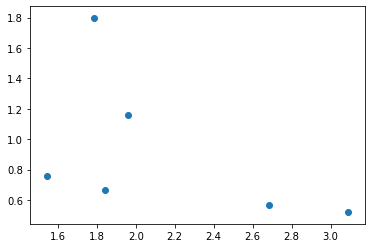

In [55]:
plt.scatter(results_df.roi, results_df.mape)
plt.show()

In [32]:
import time

t0 = time.time()


models_dict_basic = {}
for idx, metro in enumerate(info_data.Metro):
    
    try:
        # Extract training data for the zipcode
        train = pd.DataFrame(time_data.loc[])
        train.rename(columns={zipcode: 'y'}, inplace=True)
        train.loc[:, 'ds'] = pd.to_datetime(train.index, format='%Y-%m')
        train = train.loc[train.ds < '2018-01-01', :]
        train = train.loc[:, ['ds', 'y']]

        # Find the last date in the training data
        last_date = train.ds[-1]

        # create the model
        m = Prophet(
            growth='linear',
            weekly_seasonality=False,
            daily_seasonality=False,
            n_changepoints=15,
            changepoint_prior_scale=10,
            mcmc_samples=0
        )
        m.fit(train)

        # Create future data frame
        future = m.make_future_dataframe(periods=12, freq='m', include_history=True)

        # Adjust dates in future to be on the first of the month
        new_range = future.ds > last_date
        future.loc[new_range, :] = future.loc[new_range, :] + pd.Timedelta('1 day')

        # Forecast pricies into the future
        forecast = m.predict(future)
        forecast.set_index(future.ds, drop=False, inplace=True)
        #forecast.index.rename('Date', inplace=True)

        # Merge the true data into the forecast dataframe
        forecast.loc[:, 'y'] = train.loc[forecast.ds, 'y'].values

        # Get metrics for the model
        mape = calc_mape(forecast.loc[train.index, :])
               #calc_mape(forecast.loc[train.index, :])
        roi = calc_roi_range(forecast)

        if idx % 5 == 0:
            print('Progress: {}/{}, Zip: {}'.format(idx, info_data.shape[0], zipcode))
            print("Time elapsed: {:.2f} s".format(time.time() - t0))

        models_dict_basic.update({zipcode: {'m': m, 'forecast': forecast, 'mape': mape, 'roi': roi[0], 'low': roi[1], 'high': roi[2]}})
    except Exception as e:
        print('Progress: {}/{}, Zip: {}'.format(idx+1, info_data.shape[0], zipcode))
        print(e)
        
    if idx >= 5:
        break

print("Time elapsed: {:.2f} s".format(time.time() - t0))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,1997-01-01,142082.085313,139721.712366,143752.984945,142082.085313,142082.085313,-270.213961,-270.213961,-270.213961,-270.213961,-270.213961,-270.213961,0.0,0.0,0.0,141811.871352,140200.0
1,1997-02-01,141861.139790,139671.233788,143738.370818,141861.139790,141861.139790,-213.169025,-213.169025,-213.169025,-213.169025,-213.169025,-213.169025,0.0,0.0,0.0,141647.970765,140600.0
2,1997-03-01,141661.576091,139574.437258,143453.384326,141661.576091,141661.576091,-137.362945,-137.362945,-137.362945,-137.362945,-137.362945,-137.362945,0.0,0.0,0.0,141524.213145,141300.0
3,1997-04-01,141440.630567,139413.673631,143277.580946,141440.630567,141440.630567,-91.547215,-91.547215,-91.547215,-91.547215,-91.547215,-91.547215,0.0,0.0,0.0,141349.083352,141800.0
4,1997-05-01,141226.812318,139293.272743,143162.812302,141226.812318,141226.812318,-25.261106,-25.261106,-25.261106,-25.261106,-25.261106,-25.261106,0.0,0.0,0.0,141201.551212,142200.0
5,1997-06-01,141005.866794,139202.852698,143102.187738,141005.866794,141005.866794,35.570620,35.570620,35.570620,35.570620,35.570620,35.570620,0.0,0.0,0.0,141041.437414,142400.0
6,1997-07-01,140792.048545,138998.596231,142837.592040,140792.048545,140792.048545,68.937943,68.937943,68.937943,68.937943,68.937943,68.937943,0.0,0.0,0.0,140860.986488,142400.0
7,1997-08-01,140571.103021,138701.524850,142538.802904,140571.103021,140571.103021,68.827655,68.827655,68.827655,68.827655,68.827655,68.827655,0.0,0.0,0.0,140639.930676,142100.0
8,1997-09-01,140350.157497,138410.548645,142162.575850,140350.157497,140350.157497,63.237951,63.237951,63.237951,63.237951,63.237951,63.237951,0.0,0.0,0.0,140413.395448,141800.0
9,1997-10-01,140136.339250,138227.551929,142155.299738,140136.339250,140136.339250,84.216499,84.216499,84.216499,84.216499,84.216499,84.216499,0.0,0.0,0.0,140220.555749,141400.0


In [141]:

forecast.loc[:, 'y'] = train.loc[forecast.ds, 'y'].values



forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,y,yhat,yhat_lower,yhat_upper
244,2017-05-01,170700.0,175784.940839,170830.527516,180711.278959
245,2017-06-01,168600.0,176480.965544,171420.109943,181475.326678
246,2017-07-01,169700.0,177340.117418,172252.741222,182354.895675
247,2017-08-01,174600.0,178349.283478,173513.997781,183351.872123
248,2017-09-01,178100.0,179228.853854,174470.182488,184295.130728
249,2017-10-01,177600.0,179963.657210,174946.760456,185225.056536
250,2017-11-01,176100.0,180661.340701,176036.831355,185537.556778
251,2017-12-01,174100.0,181292.274489,176285.401425,186414.734560
252,2018-01-01,NaN,182678.710991,177672.540415,188011.983465
253,2018-02-01,NaN,183272.191806,178327.201637,188480.445972


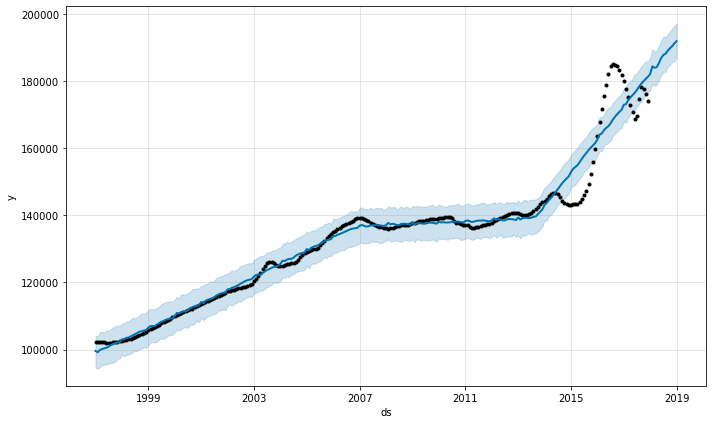

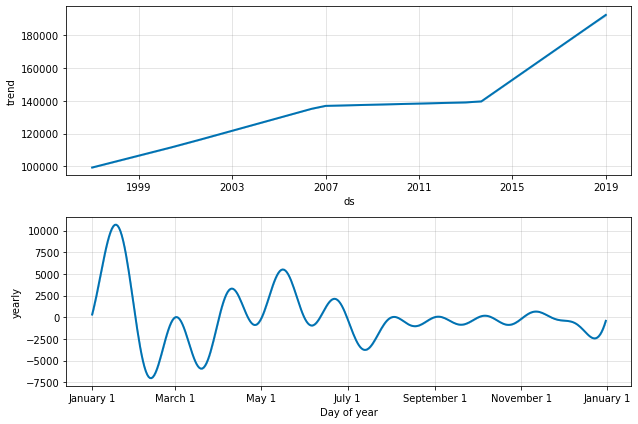

In [64]:
pd.plotting.register_matplotlib_converters()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


In [ ]:
# Python
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

# Python
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 40 forecasts with cutoffs between 1999-03-13 00:00:00 and 2018-06-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.


In [35]:
#help(Prophet)